<a href="https://colab.research.google.com/github/farhan1503001/Neural-Style-Transfer/blob/main/Neural_Style_Transfer_VGG_19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL

# Building VGG-19 Model

In [6]:
vgg=tf.keras.applications.vgg19.VGG19(include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [7]:
for layer in vgg.layers:
  layer.trainable=False
vgg.trainable=False

# Preprocessing Image

In [8]:
def pre_processor(path):
  image=PIL.Image.open(fp=path)
  image=image.convert('RGB')
  image=tf.keras.preprocessing.image.img_to_array(image)
  input_image=tf.keras.applications.vgg19.preprocess_input(image)
  input_image=np.expand_dims(input_image,axis=0)
  return input_image

In [9]:
content_p=pre_processor('/content/Project-NST/content10.jpg')
style_p=pre_processor('/content/Project-NST/style12.jpg')

print("Content_image shape: ",content_p.shape)
print("Style image shape: ",style_p.shape)

Content_image shape:  (1, 487, 487, 3)
Style image shape:  (1, 750, 600, 3)


In [10]:
denormalizer=[103.939,116.779,123.68]

In [11]:
def decompresser(image):
  image[0,:,:,0]+=denormalizer[0]
  image[0,:,:,1]+=denormalizer[1]
  image[0,:,:,2]+=denormalizer[2]
  
  img=np.clip(image,0,255).astype('int32')
  img=np.squeeze(img,axis=0)

  return img

In [12]:
content_d=decompresser(content_p)
style_d=decompresser(style_p)

print("Content_image shape: ",content_d.shape)
print("Style image shape: ",style_d.shape)

Content_image shape:  (487, 487, 3)
Style image shape:  (750, 600, 3)


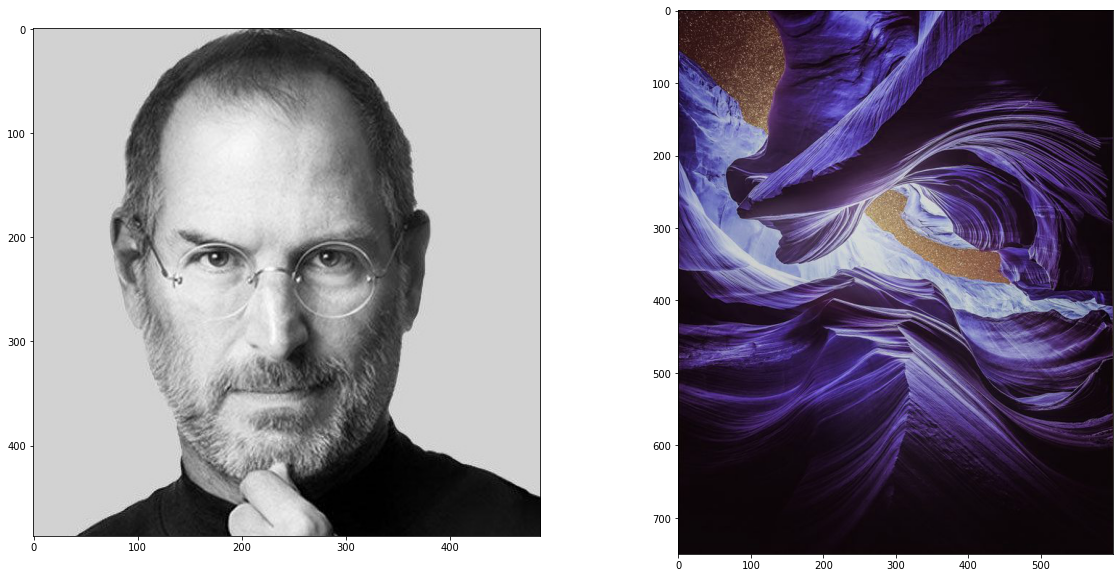

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

# Style and Content Feature Extraction Process

In [14]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [15]:
 style_layers={
      'block1_conv1',
      'block2_conv1',
      'block3_conv1',
      'block4_conv1',
             #content feature
      'block5_conv1'
  }

In [21]:
def feature_extractor(content_image,style_image,model=vgg):
  Features_style={}
  Features_content={}
  style_models=[tf.keras.Model(inputs=model.inputs,
                                outputs=model.get_layer(layer).output) for layer in style_layers]
  con_model=tf.keras.Model(inputs=model.input,outputs=model.get_layer('block4_conv2').output)
  i=0
  for style_model in style_models:
    style_f=style_model(style_image)
    Features_style[i]=style_f
    i=i+1
  con_f=con_model(content_image)

  return Features_style,con_f
  

In [22]:
style_f,content_f=feature_extractor(content_p,style_p)

# Defining Gram Metrix

In [38]:
def gram_matrix(tensor):
  b,h,w,c=tensor.shape
  image=tf.reshape(tensor=tensor,shape=(h*w*b,c))
  gram=tf.matmul(image,image,transpose_a=True)
  return gram/tf.cast(h*w*b,dtype=tf.float32)

In [40]:
style_g={layer: gram_matrix(style_f[layer]) for layer in style_f}
style_g[1]

<tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[ 53947.75  ,  25379.014 ,  17200.06  , ...,  24542.615 ,
         39021.832 ,  41259.668 ],
       [ 25379.014 , 473394.6   ,  24097.076 , ...,   9020.915 ,
        126997.72  , 116669.52  ],
       [ 17200.06  ,  24097.076 ,  25834.219 , ...,   7417.9683,
         22312.326 ,  23436.977 ],
       ...,
       [ 24542.615 ,   9020.915 ,   7417.9683, ...,  35823.938 ,
         22331.062 ,  22312.38  ],
       [ 39021.832 , 126997.72  ,  22312.326 , ...,  22331.062 ,
        168581.44  ,  82767.82  ],
       [ 41259.668 , 116669.52  ,  23436.977 , ...,  22312.38  ,
         82767.82  , 141013.38  ]], dtype=float32)>

# Defining Content Loss Function

In [41]:
#Now we will define two types of loss content and Loss function 
#Here content layer are 4_2 so loss will be according to that .
def content_loss(target_conv4_2,content_conv4_2):
  loss=tf.reduce_mean((content_conv4_2-target_conv4_2)**2)
  return loss

#Defining Style Loss Function

In [52]:
#Style weights are concerned with all other layers except 4_2 here target image 
style_weights=[
     1.0,#'block1_conv1
    0.75, #'block2_conv1
    0.2, #'block3_conv1
    0.2,    #'block4_conv1
    0.2  #'block5_conv1
]

In [62]:
def style_loss(style_weights,target_features,style_gram):
  loss=0.0
  for layer in range(len(style_weights)):
    target_f=target_features[layer]
    target_g=gram_matrix(target_f)
    style_g=style_gram[layer]
    b,c,h,w=target_f.shape
    layer_loss=style_weights[layer]*tf.reduce_mean((target_g-style_g)**2)
    loss=loss+layer_loss/(c*h*w)
  return loss

In [63]:
target=tf.Variable(content_p,trainable=True)
target_s_feature,target_features=feature_extractor(target,target,vgg)
print("Content Loss : ",content_loss(target_conv4_2=target_features,content_conv4_2=content_f))
print("Style Loss : ",style_loss(style_weights,target_s_feature,style_g))

Content Loss :  tf.Tensor(0.0, shape=(), dtype=float32)
Style Loss :  tf.Tensor(10868.591, shape=(), dtype=float32)


In [64]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.036)
epochs=3000
alpha=1
beta=1e5
steps=500

In [66]:
def total_loss(s_loss,c_loss):
  total_loss=alpha*c_loss+beta*s_loss
  return total_loss

In [71]:
results=[]
for i in range(epochs):
  with tf.GradientTape() as tape:
    target_s_feature,target_feature=feature_extractor(target,target,vgg)
    c_loss=content_loss(target_conv4_2=target_feature,content_conv4_2=content_f)
    s_loss=style_loss(style_weights,target_s_feature,style_g)
    t_loss=total_loss(s_loss,c_loss)
  grads=tape.gradient(t_loss,target)
  optimizer.apply_gradients([(grads,target)])

  if i%steps==0:
    print("Total loss at epoch ",i," is :",t_loss)
    results.append(decompresser(target.numpy()))

Total loss at epoch  0  is : tf.Tensor(1086859100.0, shape=(), dtype=float32)
Total loss at epoch  500  is : tf.Tensor(99368344.0, shape=(), dtype=float32)
Total loss at epoch  1000  is : tf.Tensor(51462730.0, shape=(), dtype=float32)
Total loss at epoch  1500  is : tf.Tensor(34622710.0, shape=(), dtype=float32)
Total loss at epoch  2000  is : tf.Tensor(26079988.0, shape=(), dtype=float32)
Total loss at epoch  2500  is : tf.Tensor(20823510.0, shape=(), dtype=float32)


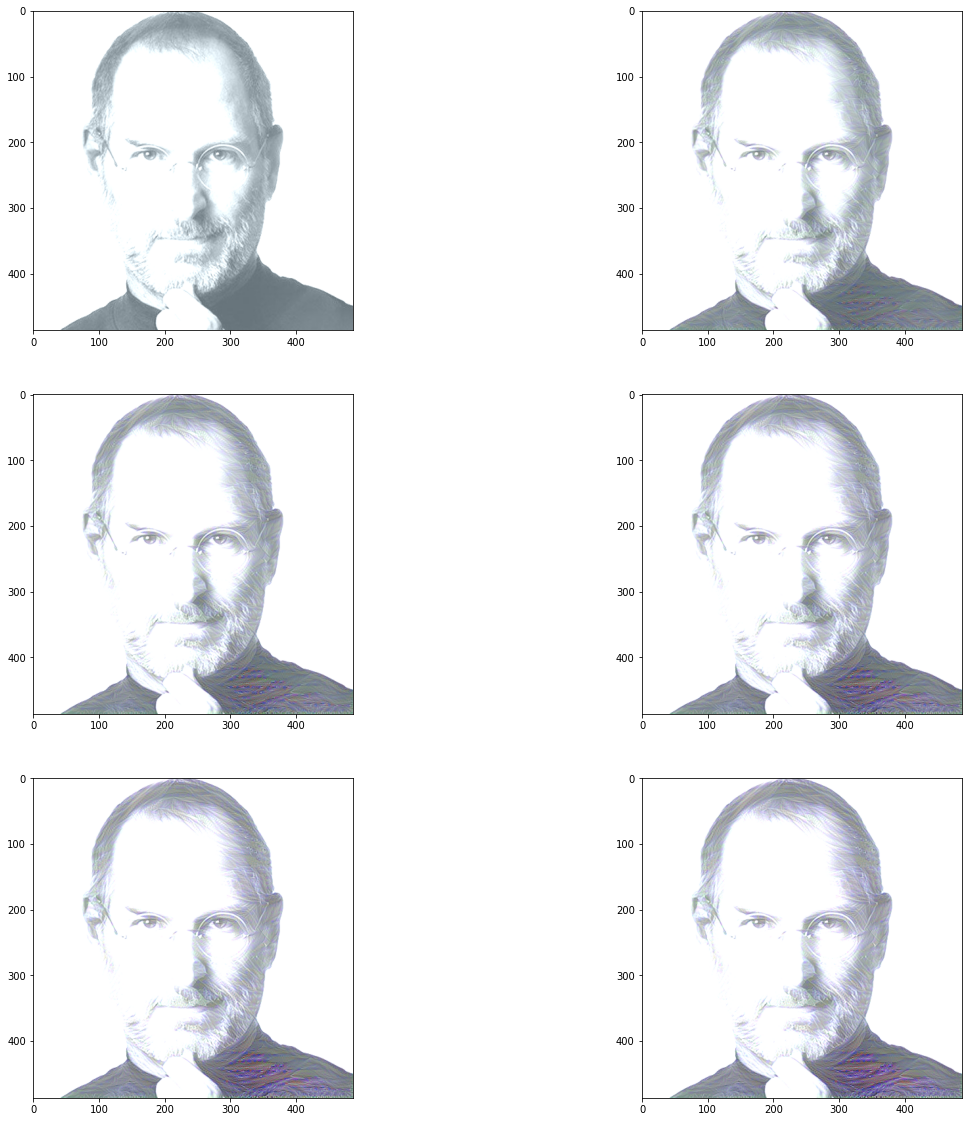

In [72]:
plt.figure(figsize=(20,20))
for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

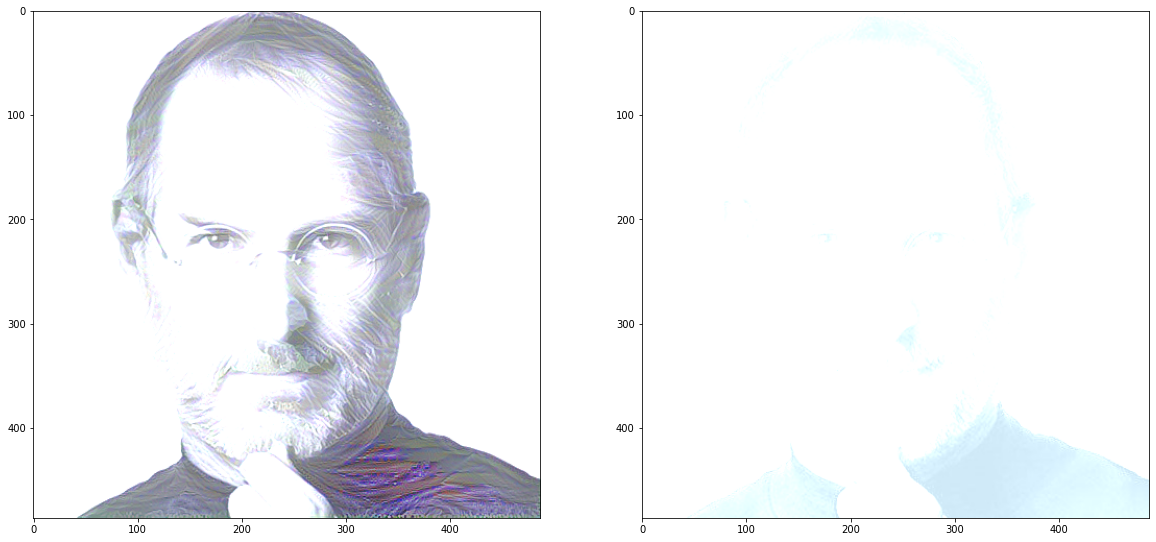

In [74]:
target_copy=decompresser(target.numpy())
content_copy=decompresser(content_p)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,20))
ax1.imshow(target_copy)
ax2.imshow(content_copy)